# Conditional Neural Processes (CNP).
[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import datetime
import numpy as np
import os
from resum.utilities import plotting_utils_cnp as plotting
from resum.utilities import utilities as utils
from resum.conditional_neural_process import DataGeneration
from resum.conditional_neural_process import DeterministicModel
from torch.utils.tensorboard import SummaryWriter
import csv
import yaml

In [ ]:
with open("binary-black-hole/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

PLOT_AFTER = int(config_file["cnp_settings"]["plot_after"])
torch.manual_seed(0)
FILES_PER_BATCH = config_file["cnp_settings"]["files_per_batch_train"]
target_range = config_file["simulation_settings"]["target_range"]
is_binary = target_range[0] >= 0 and target_range[1] <= 1

version_cnp= config_file["cnp_settings"]["version"]
version_lf= config_file["simulation_settings"]["version_lf"]

path_out = config_file["path_settings"]["path_out"]
f_out = config_file["path_settings"]["f_out"]



In [3]:
x_size, y_size = utils.get_feature_and_label_size(config_file)
theta_size=len(config_file["simulation_settings"]["theta_headers"])

In [4]:
d_x, d_in, representation_size, d_out = x_size , x_size+y_size, 32, y_size+1
encoder_sizes = [d_in, 32, 64, 128, 128, 128, 64, 48, representation_size]
decoder_sizes = [representation_size + d_x, 32, 64, 128, 128, 128, 64, 48, d_out]

model = DeterministicModel(encoder_sizes,decoder_sizes)
model.load_state_dict(torch.load(f'binary-black-hole/out/cnp/cnp_model.pth'))
model.eval()

DeterministicModel(
  (_encoder): DeterministicEncoder(
    (linears): ModuleList(
      (0): Linear(in_features=31, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): Linear(in_features=64, out_features=48, bias=True)
      (7): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (_decoder): DeterministicDecoder(
    (linears): ModuleList(
      (0): Linear(in_features=62, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): Linear(in_features=64, out_features=48, bias=True)
      (7): Linear(

2025-04-05 18:44:15 Iteration: 0/0, train loss: 0.7043 (vs BCE 0.4358)


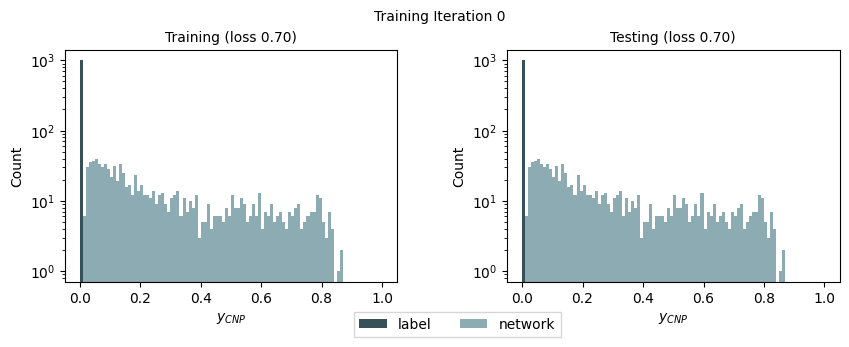

KeyboardInterrupt: 

In [5]:
bce = nn.BCELoss()
iter_testing = 0

# create a PdfPages object
test_idx=0
it_batch = 0

with open(f'{path_out}/output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    headers = ['# n_samples'] + [*config_file["simulation_settings"]["theta_headers"]] + ['y_cnp', 'y_cnp_err', 'y_raw', 'log_prop','bce']
    writer.writerow(headers)

for p, path in enumerate(config_file["path_settings"]["path_to_test_files"]):
    
    USE_DATA_AUGMENTATION = False
    # load data:

    dataset_train = DataGeneration(mode = "testing", config_file=config_file, 
                                   path_to_files=path, 
                                   use_data_augmentation=USE_DATA_AUGMENTATION, 
                                   batch_size=config_file["cnp_settings"]["batch_size_test"][p], 
                                   files_per_batch=FILES_PER_BATCH)
    dataset_train.set_loader()
    dataloader_train = dataset_train.dataloader


    #it_batch = 0
    
    for b, batch in enumerate(dataloader_train):
        batch_formated=dataset_train.format_batch_for_cnp(batch,config_file["cnp_settings"]["context_is_subset"] )
        # Get the predicted mean and variance at the target points for the testing set
        log_prob, mu, sigma = model(batch_formated.query, batch_formated.target_y, is_binary)
        
        # Define the loss
        loss = -log_prob.mean()
        
        if is_binary:
            loss_bce = bce(mu, batch_formated.target_y)
        else:
            loss_bce=-1

        
        
        mu=mu[0].detach().numpy()
        sigma = sigma[0].detach().numpy()

        
        theta=batch_formated.query[1][0].detach().numpy()
        row = np.array([len(mu)] + theta[0,:theta_size].tolist() + [np.mean(mu), np.sqrt(np.sum(sigma**2)) / len(sigma), np.mean(batch_formated.target_y.detach().numpy()),loss.item(), loss_bce.item()])
        # Reshape to 2D array (one row)
        row = row.reshape(1, -1)

        # Write the row to the CSV file with 5 decimal places for each number
        with open(f'{path_out}/output.csv', mode='a', newline='') as file:
            np.savetxt(file, row, delimiter=",", fmt="%.5f")

        if it_batch % PLOT_AFTER == 0:
            mu_testing=mu
            loss_testing=loss
            print('{} Iteration: {}/{}, train loss: {:.4f} (vs BCE {:.4f})'.format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),p, it_batch,loss, loss_bce))
            if y_size ==1:
                    fig = plotting.plot(mu, batch_formated.target_y[0].detach().numpy(), f'{loss:.2f}', mu_testing, batch_formated.target_y[0].detach().numpy(), f'{loss_testing:.2f}', target_range, it_batch)
            else:
                for k in range(y_size):
                        fig = plotting.plot(mu[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss:.2f}', mu_testing[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss_testing:.2f}', target_range, it_batch)
                        
        it_batch+=1
